### Tiny Imagenet Visual Recognition Challenge

Tiny Imagenet has 200 Classes, each class has 500 traininig images, 50 Validation Images and 50 test images. Label Classes and Bounding Boxes are provided. More details can be found at https://tiny-imagenet.herokuapp.com/

This challenge is part of Stanford Class CS 213N

In [14]:
import os
import matplotlib
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import zipfile
import requests, StringIO
from sklearn import preprocessing


BATCH_SIZE = 20
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = './tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
IMAGES_URL = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

def download_images(url):
    if (os.path.isdir(TRAINING_IMAGES_DIR)):
        print ('Images already downloaded...')
        return
    r = requests.get(url, stream=True)
    print ('Downloading ' + url )
    zip_ref = zipfile.ZipFile(StringIO.StringIO(r.content))
    zip_ref.extractall('./')
    zip_ref.close()

def load_training_images(image_dir, batch_size=500):

    image_index = 0
    
    images = np.ndarray(shape=(NUM_IMAGES, IMAGE_ARR_SIZE))
    names = []
    labels = []                       
    
    # Loop through all the types directories
    for type in os.listdir(image_dir):
        if os.path.isdir(image_dir + type + '/images/'):
            type_images = os.listdir(image_dir + type + '/images/')
            # Loop through all the images of a type directory
            batch_index = 0;
            #print ("Loading Class ", type)
            for image in type_images:
                image_file = os.path.join(image_dir, type + '/images/', image)

                # reading the images as they are; no normalization, no color editing
                image_data = mpimg.imread(image_file) 
                #print ('Loaded Image', image_file, image_data.shape)
                if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
                    images[image_index, :] = image_data.flatten()

                    labels.append(type)
                    names.append(image)
                    
                    image_index += 1
                    batch_index += 1
                if (batch_index >= batch_size):
                    break;
                    
    return (images, np.asarray(labels), np.asarray(names))

def get_label_from_name(data, name):
    for idx, row in data.iterrows():       
        if (row['File'] == name):
            return row['Class']
        
    return None


def load_validation_images(testdir, validation_data, batch_size=NUM_VAL_IMAGES):
    labels = []
    names = []
    image_index = 0
    
    images = np.ndarray(shape=(batch_size, IMAGE_ARR_SIZE))
    val_images = os.listdir(testdir + '/images/')
           
    # Loop through all the images of a val directory
    batch_index = 0;
    
    
    for image in val_images:
        image_file = os.path.join(testdir, 'images/', image)
        #print (testdir, image_file)

        # reading the images as they are; no normalization, no color editing
        image_data = mpimg.imread(image_file) 
        if (image_data.shape == (IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)):
            images[image_index, :] = image_data.flatten()
            image_index += 1
            labels.append(get_label_from_name(validation_data, image))
            names.append(image)
            batch_index += 1
            
        if (batch_index >= batch_size):
            break;
    
    print ("Loaded Validation images ", image_index)
    return (images, np.asarray(labels), np.asarray(names))
   
    

def plot_object(data):
    plt.figure(figsize=(1,1))
    image = data.reshape(IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_objects(instances, images_per_row=10, **options):
    size = IMAGE_SIZE
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size,NUM_CHANNELS) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()
    
def get_next_batch(batchsize=50):
    for cursor in range(0, len(training_images), batchsize):
        batch = []
        batch.append(training_images[cursor:cursor+batchsize])
        batch.append(training_labels_encoded[cursor:cursor+batchsize])       
        yield batch

def get_next_labels(batchsize=50):
    for cursor in range(0, len(training_images), batchsize):
        yield training_labels_encoded[cursor:cursor+batchsize]  
    
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Images already downloaded...
('First 30 Training Labels', array([ 27, 174,  26, 196, 149,   3,  87,  10,   9,  40, 170, 191,  57,
        74, 192, 174,  59,  23,  29,  16,  70,  83, 179,  85, 127,  10,
       194, 162, 106,  62]))


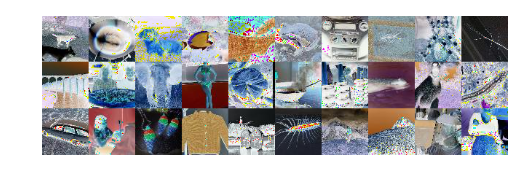

('Loaded Validation images ', 20)


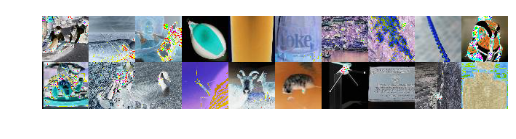

[107 139  90 138  67 135 198  38  88  63 107 107  11  42  51  23 167  78
 195 134]


In [15]:
download_images(IMAGES_URL)
training_images, training_labels, training_files = load_training_images(TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)

shuffle_index = np.random.permutation(len(training_labels))
training_images = training_images[shuffle_index]
training_labels = training_labels[shuffle_index]
training_files  = training_files[shuffle_index]

le = preprocessing.LabelEncoder()
training_le = le.fit(training_labels)
training_labels_encoded = training_le.transform(training_labels)

print ("First 30 Training Labels", training_labels_encoded[0:30])
plot_objects(training_images[0:30])


val_data = pd.read_csv(VAL_IMAGES_DIR + 'val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_images, val_labels, val_files = load_validation_images(VAL_IMAGES_DIR, val_data, batch_size=BATCH_SIZE)
val_labels_encoded = training_le.transform(val_labels)
plot_objects(val_images[0:30])
print (val_labels_encoded[0:30])

In [16]:
height = IMAGE_SIZE
width = IMAGE_SIZE
channels = NUM_CHANNELS
n_inputs = height * width * channels
n_outputs = 200

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
y = tf.placeholder(tf.int32, shape=[None], name="y")

#input shape [-1, 64, 64, 3]
conv1 = tf.layers.conv2d(
            inputs=X_reshaped, 
            filters=32, 
            kernel_size=[5,5],
            padding='SAME',
            activation=tf.nn.relu, 
            name="conv1")

#shape after conv1: [-1, 64, 64, 32]
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

conv2 = tf.layers.conv2d(
            inputs=pool1, 
            filters=64,
            kernel_size=[5,5],
            padding='SAME',
            activation=tf.nn.relu, 
            name="conv2")

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Dense Layer
pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=dense, rate=0.4)
dropout_reshape = tf.reshape(dropout, [-1, 8 * 8 * 64])

# Logits Layer
logits = tf.layers.dense(inputs=dropout_reshape, units=200, name='output')
Y_proba = tf.nn.softmax(logits, name="Y_proba")

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
n_epochs = 10
batch_size = 10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch in get_next_batch():
            X_batch, y_batch = batch[0], batch[1]
            print ('Training set', X_batch.shape, y_batch.shape)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
       
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: val_images, y: val_labels_encoded})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./tiny_imagenet")

('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))
('Training set', (50, 12288), (50,))


KeyboardInterrupt: 